In [1]:
%%capture
!pip install wordcloud
!pip install pyLDAvis
!pip install nltk

In [2]:
%%capture
import pandas as pd
import numpy as np
import nltk
import regex as re
from nltk import download, FreqDist
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')

In [3]:
stop_words=stopwords.words('english')

In [9]:
tweets_df = pd.read_csv('global_warming_tweets.csv', lineterminator='\n')

In [11]:
tweets_df = tweets_df.loc[:, ~tweets_df.columns.str.contains('^Unnamed')]

In [12]:
tweets_df = tweets_df.dropna()

In [13]:
tweets_df

,date,content,id,retweetCount,hashtags
0,2018-03-30 23:51:02+00:00,@StormSignalSA If the #FlatEarth #Climatard Br...,979868635056414720,0,"['FlatEarth', 'Climatard', 'GlobalWarming', 'l..."
1,2018-03-30 23:47:01+00:00,RT @climatereality: 9 Questions about #Climate...,979867626557071361,1,"['Climatechange', 'globalwarming', 'sustainabi..."
2,2018-03-30 23:37:48+00:00,#FreeSunTree #LandDefender #Secwepemc #Unceded...,979865304493969408,2,"['FreeSunTree', 'LandDefender', 'Secwepemc', '..."
3,2018-03-30 23:31:50+00:00,"#OMG, so desperate liars!\n#GlobalWarming is a...",979863802920435712,0,"['OMG', 'GlobalWarming', 'hoax']"
4,2018-03-30 23:30:57+00:00,#Climatechange #GlobalWarming aren't enough 4 ...,979863583159758848,2,"['Climatechange', 'GlobalWarming', 'FirePruitt']"
...,...,...,...,...,...
892952,2018-03-30 00:16:49+00:00,Mueller pushes Gates on collusion https://t.co...,979512738400518144,1,"['zen', 'art', 'artmarketing', 'sfmoma', 'bbc'..."
892953,2018-03-30 00:10:30+00:00,"A BOOMERS “extra” (c) stevenn beck, here’s\n“S...",979511145248837633,0,"['stevennbeck', 'babyboomers', 'boomerscomics'..."
892954,2018-03-30 00:03:11+00:00,"A BOOMERS “extra” (c) stevenn beck, here’s\n“S...",979509305421586432,0,"['stevennbeck', 'babyboomers', 'boomerscomics'..."
892955,2018-03-30 00:01:13+00:00,Trees can reduce air-conditioning needs by at ...,979508811231789056,0,"['spreadawareness', 'saveplanet', 'globalwarmi..."


In [14]:
# Remove emojis

def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

In [15]:
# remove punctuations

def clean_tweets(tweet):
  # 
  # lowercase the text
  # tweet = tweet.lower()
  # print('tweets:::', type(tweet)) 
  # remove mentions
    tweet = re.sub('@[\w]*','',tweet) 

    # remove hashtags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # remove urls
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)

    # remove punctions
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # remove numbers
    tweet = re.sub(r'\d+', '', tweet)

    # remove front space
    tweet = tweet.lstrip(' ')
    
    tweet = remove_emoji(tweet)

    return tweet

tweets_df['content'] = tweets_df['content'].apply(lambda tweet: clean_tweets(tweet))

<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
/var/folders/q4/fx48tqn162gg79xk8r2r6prh0000gn/T/ipykernel_21463/1976288668.py:9: DeprecationWarning: invalid escape sequence \w
  tweet = re.sub('@[\w]*','',tweet)


In [16]:
tweets_df.shape

(892957, 5)

In [17]:
# Generate Sentiments of the Tweets

sid = SentimentIntensityAnalyzer()

tweets_df['Positive Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['pos'])
tweets_df['Neutral Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['neu'])
tweets_df['Negative Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['neg'])
tweets_df['Polarity'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

tweets_df['Sentiment'] = ''

tweets_df.loc[tweets_df['Polarity'] > 0,'Sentiment']='Positive'
tweets_df.loc[tweets_df['Polarity'] == 0,'Sentiment']='Neutral'
tweets_df.loc[tweets_df['Polarity'] <0,'Sentiment']='Negative'

In [18]:
tweets_df[tweets_df['Sentiment'] == 'Positive'].shape

(311278, 10)

In [19]:
tweets_df[tweets_df['Sentiment'] == 'Neutral'].shape

(290046, 10)

In [20]:
tweets_df[tweets_df['Sentiment'] == 'Negative'].shape

(291633, 10)

In [21]:
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

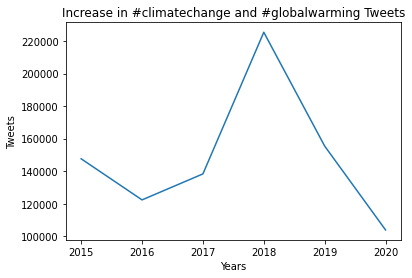

In [22]:
%matplotlib inline
tweets_list = []
years = [2015, 2016, 2017, 2018, 2019, 2020]

for year in years:
    tweets_list.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year)].shape[0])

plt.xlabel('Years')
plt.ylabel('Tweets')
plt.title('Increase in #climatechange and #globalwarming Tweets')

plt.plot(years,tweets_list)


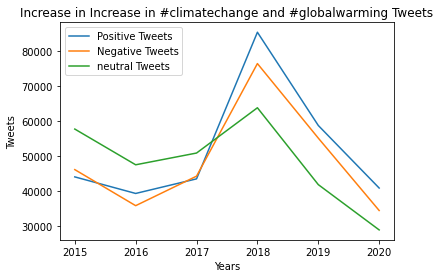

In [23]:
positive_tweets = []
negative_tweets = []
neutral_tweets = []



for year in years:
    positive_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Positive')].shape[0])
    negative_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Negative')].shape[0])
    neutral_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Neutral')].shape[0])


plt.xlabel('Years')
plt.ylabel('Tweets')
plt.title('Increase in Increase in #climatechange and #globalwarming Tweets')
plt.plot(years, positive_tweets, label='Positive Tweets')
plt.plot(years, negative_tweets, label='Negative Tweets')
plt.plot(years, neutral_tweets, label='neutral Tweets')

plt.legend()

([<matplotlib.patches.Wedge at 0x2cf5999d0>,
 [Text(0.7555783204844118, 1.4668338016332854, 'Positive'),
  Text(-1.6460606622103495, -0.11394865652400649, 'Neutral'),
  Text(0.8550736312778598, -1.4111516874855428, 'Negative')],
 [Text(0.4121336293551336, 0.8000911645272464, '34.86%'),
  Text(-0.8978512702965542, -0.06215381264945807, '32.48%'),
  Text(0.4664037988788326, -0.7697191022648413, '32.66%')])

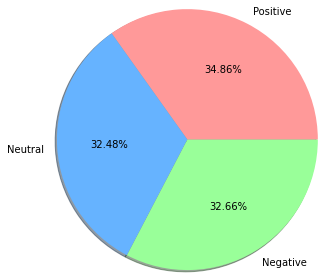

In [24]:
# pie chart of sentiments 
pie_labels = ['Positive', 'Neutral', 'Negative']
pie_values = [tweets_df[tweets_df['Sentiment'] == 'Positive'].shape[0], tweets_df[tweets_df['Sentiment'] == 'Neutral'].shape[0], tweets_df[tweets_df['Sentiment'] == 'Negative'].shape[0]]

plt.pie(pie_values, labels=pie_labels, radius=1.5, autopct='%0.2f%%', shadow=True, colors=['#ff9999','#66b3ff','#99ff99'])

In [25]:
# Tokenisation of tweets and remove stop words
stop_words.extend(['rt', 'amp'])
def tokenize_tweet(tweet):

    # print('clean_tweet::',clean_tweet)
    token_list = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles= True).tokenize(tweet)
    clean_tweet = [w for w in token_list if not w.lower() in stop_words]
    return clean_tweet
tweets_df['Tokenised'] = tweets_df['content'].apply(lambda text: tokenize_tweet(text))

In [26]:
def tweet_token_cloud(tweet_list):
    comment_words = ''
    for tokens in tweet_list:

    # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    return comment_words


/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-0

/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-0

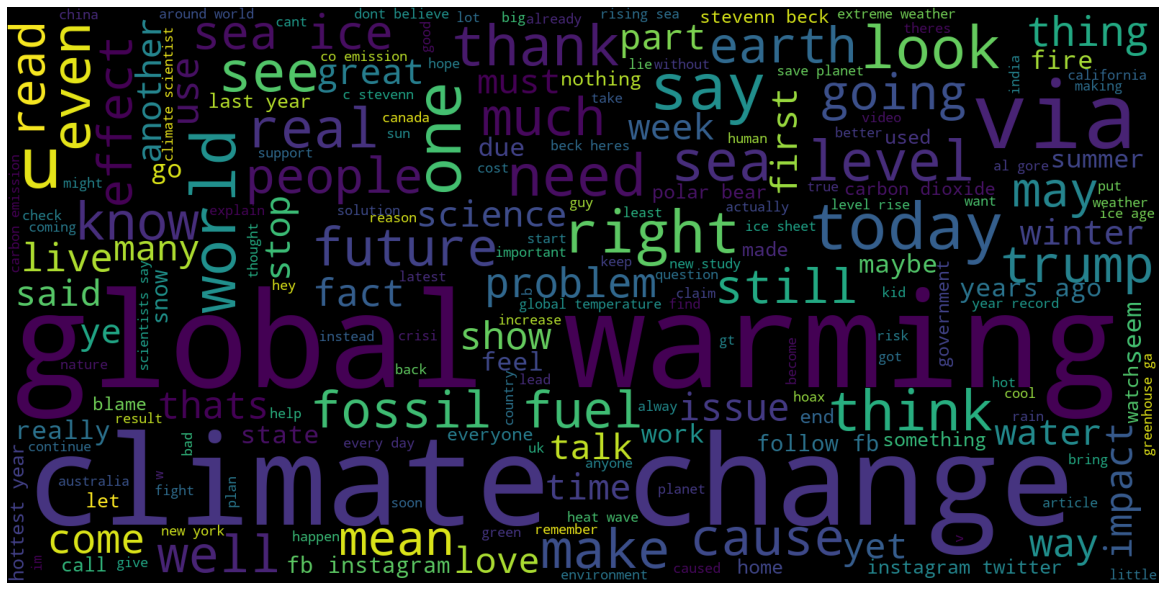

In [27]:
# Creating Word Cloud for all the tweets
stopwords = set(STOPWORDS)

stopwords.update(['rt']) 
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 15).generate(tweet_token_cloud(tweets_df['Tokenised']))
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [29]:
id2word = corpora.Dictionary(tweets_df['Tokenised'])

# Creating Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in tweets_df['Tokenised']]

In [30]:
# LDA mode training

from pprint import pprint

# Set Number of Topics

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6)


In [31]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, id2word)

/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yashikasorathiaicloud.com/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.109911 -0.057350       1        1  19.246457
3      0.106669  0.132733       2        1  19.063370
0     -0.193494  0.128561       3        1  18.425394
1     -0.090124 -0.136006       4        1  17.578574
4     -0.044572 -0.079048       5        1  13.641868
5      0.111609  0.011110       6        1  12.044337, topic_info=        Term          Freq         Total Category  logprob  loglift
157  warming  60764.000000  60764.000000  Default  30.0000  30.0000
252   global  69832.000000  69832.000000  Default  29.0000  29.0000
49   climate  80053.000000  80053.000000  Default  28.0000  28.0000
48    change  72609.000000  72609.000000  Default  27.0000  27.0000
67       ice  23759.000000  23759.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
187     make   2957.454069  15951.473990   Topic6  -5.6939   0.4314
343      get   2930.871838  18756.510532   Topic6  -5.7029   0.2603
92       via   3166.035076  35355.423276   Topic6  -5.6258  -0.2964
20     would   2698.874388  16848.782936   Topic6  -5.7854   0.2851
163     like   2747.435499  28012.793878   Topic6  -5.7676  -0.2054

[630 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
17445      1  0.994082  abstracts
17445      6  0.004008  abstracts
6921       1  0.019646         ac
6921       2  0.871866         ac
6921       3  0.042679         ac
...      ...       ...        ...
1377       3  0.003276      youll
1377       4  0.001092      youll
1377       6  0.029488      youll
7215       3  0.045698    youtube
7215       5  0.952930    youtube

[2120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5, 6])

In [33]:
# Topic modeling on negative tweets
id2word_negative = corpora.Dictionary(tweets_df[tweets_df['Sentiment'] == 'Negative']['Tokenised'])

# Creating Term Document Frequency 
corpus_negative = [id2word_negative.doc2bow(text) for text in tweets_df[tweets_df['Sentiment'] == 'Negative']['Tokenised']]

In [34]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False): 
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []
    for d in corpus:
        tmp = {i:0 for i in range(6)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

In [35]:
top_dist, lda_keys= get_doc_topic_dist(lda_model, corpus, True)
tweets_df['Topic'] = pd.DataFrame(lda_keys)

In [36]:
tweets_df.head()

,date,content,id,retweetCount,hashtags,Positive Score,Neutral Score,Negative Score,Polarity,Sentiment,Tokenised,Topic
0,2018-03-30,If the Brigade would respect science they wo...,979868635056414720,0,"['FlatEarth', 'Climatard', 'GlobalWarming', 'l...",0.165,0.835,0.000,0.6908,Positive,"[brigade, would, respect, science, would, come...",3
1,2018-03-30,RT Questions about you were too embarrassed...,979867626557071361,1,"['Climatechange', 'globalwarming', 'sustainabi...",0.000,0.762,0.238,-0.3612,Negative,"[questions, embarrassed, ask]",1
2,2018-03-30,Land ambush,979865304493969408,2,"['FreeSunTree', 'LandDefender', 'Secwepemc', '...",0.000,1.000,0.000,0.0000,Neutral,"[land, ambush]",0
3,2018-03-30,so desperate liars\n is an enormous,979863802920435712,0,"['OMG', 'GlobalWarming', 'hoax']",0.000,0.389,0.611,-0.7408,Negative,"[desperate, liars, enormous]",0
4,2018-03-30,arent enough you to plague the world with ...,979863583159758848,2,"['Climatechange', 'GlobalWarming', 'FirePruitt']",0.000,0.884,0.116,-0.5267,Negative,"[arent, enough, plague, world, taxpayer, ripof...",5
